# Data interpolation

In [1]:
%matplotlib inline

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.signal import find_peaks, peak_widths
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [12]:
FACE_MESH = pd.read_csv('faceMesh/face_mesh.csv')

def landmarks_mapper(of_df, mp_df):
    
    OPENFACE_LANDMARKS = [i for i in range(17, 68)]
    
    final_df = of_df['frame'] # initialize the final dataframe
    for i, landmark in enumerate(OPENFACE_LANDMARKS):

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']] # select the columns from the openface dataframe
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}'] # rename the columnsk
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

In [5]:
def mse(df: pd.DataFrame):
    
    lndmk_mse = []
    for i in range(17, 68):
        
        x_mse = mean_squared_error(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_mse = mean_squared_error(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_mse.append((x_mse+y_mse)/2)
    
    video_mse = np.mean(lndmk_mse)
    
    return video_mse

### Peak detection

In [42]:
#'whack_your_boss_12','would_yourather_29','Branda_schmitz_116','dolan_dark_68','fortnite_117','pewdiepie_165','godofwar_52','burnshoes_94','juice_wrld_59','qwop_55','gta1_40','f_marry_kill_68'
video_name = 'would_you_rather_29'

openface_df = pd.read_csv(f'openFace/processed_cleansed/{video_name}_openface.csv')
mediapipe_df = pd.read_csv(f'mediaPipe/processed_cleansed/{video_name}_mediapipe.csv')

mapped_landmarks_df = landmarks_mapper(openface_df, mediapipe_df)
window_size = (lambda seconds: round(24*seconds))(0.2)
windows = mapped_landmarks_df.rolling(window=window_size, center=True) # centralized sliding window
windowized_mse = np.array([mse(window) for window in windows])

maximum, minimum = np.max(windowized_mse), np.min(windowized_mse)
windowized_mse = np.array([(x - minimum)/(maximum - minimum) for x in windowized_mse]) # min-max normlization

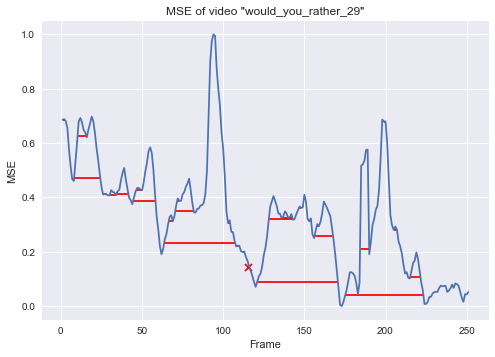

In [43]:
plt.style.use('seaborn')
plt.plot(mapped_landmarks_df.frame, windowized_mse)
plt.title(f'MSE of video "{video_name}"')
plt.xlabel('Frame')
plt.ylabel('MSE')

peaks, _ = find_peaks(windowized_mse, height=0.15)
widths = peak_widths(windowized_mse, peaks, rel_height=0.95)

for frames in widths[2:]:
    frames += mapped_landmarks_df.frame.iloc[0] # add the starting frame of the video
    
plt.plot(peaks, windowized_mse[peaks], 'x')
plt.hlines(*widths[1:], color="red")


start_index, end_index = None, None
if windowized_mse[0]>0.15:
    for index, mse_value in enumerate(windowized_mse):
        if mse_value < 0.15:
            start_index = index
            break
    
if windowized_mse[-1]>0.15:
    for index in range(len(windowized_mse)-1, -1, -1):
        if windowized_mse[index] < 0.15:
            end_index = index
            break

if start_index:
    plt.scatter(start_index, windowized_mse[start_index], marker="x", color="red")

if end_index:
    plt.scatter(end_index, windowized_mse[end_index], marker="x", color="red")
    
plt.show()

### Landmark interpolation and data cleansing

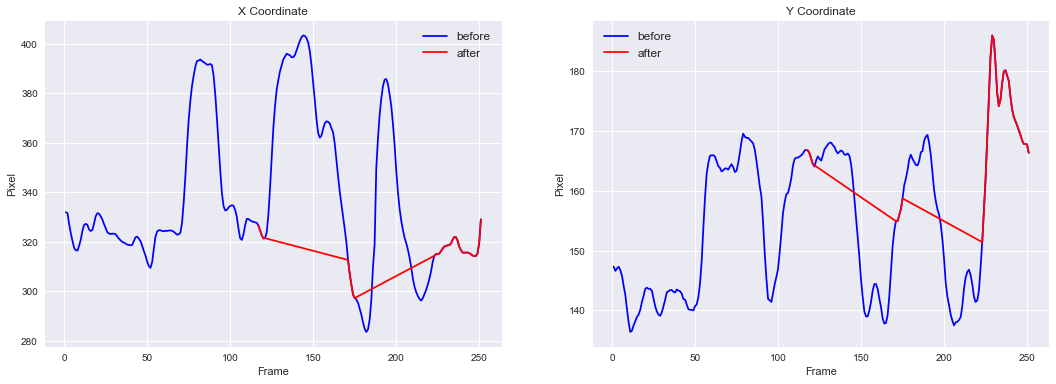

In [46]:
openface_df = pd.read_csv(f'openFace/processed_cleansed/{video_name}_openface.csv')

_, axes = plt.subplots(1, 2, figsize=(18,6))
axes = axes.flatten()

axes[0].set(title='X Coordinate', xlabel='Frame', ylabel='Pixel')
axes[1].set(title='Y Coordinate', xlabel='Frame', ylabel='Pixel')

axes[0].plot(openface_df.frame, openface_df.x_27, color='blue', label='before')
axes[1].plot(openface_df.frame, openface_df.y_27, color='blue', label='before')

if start_index:
    openface_df.drop([frame for frame in range(start_index+1)], inplace=True)
if end_index:
    openface_df.drop([frame for frame in range(end_index, openface_df.frame.size)], inplace=True)

starting_points = widths[2]
ending_points = widths[3]

for peak_points in zip(starting_points, ending_points):
    
    start = round(peak_points[0])
    end = round(peak_points[1])
    
    for i in range(68):
        openface_df.loc[start:end-2, f'x_{i}'], openface_df.loc[start:end-2, f'y_{i}'] = np.nan, np.nan
openface_df.interpolate(method='linear', axis=0, inplace=True)
      
axes[0].plot(openface_df.frame, openface_df.x_27, color='red', label='after')
axes[1].plot(openface_df.frame, openface_df.y_27, color='red', label='after')

axes[0].legend(fontsize='large')
axes[1].legend(fontsize='large')
plt.show()

### Visualization of the interpolated landmarks

In [75]:
def draw_landmark(image, landmarks_df, frame):
    
    x_regex_pat = re.compile(r'^x_[0-9]+$')
    y_regex_pat = re.compile(r'^y_[0-9]+$')
    
    x_locs = landmarks_df.columns[landmarks_df.columns.str.contains(x_regex_pat)]
    y_locs = landmarks_df.columns[landmarks_df.columns.str.contains(y_regex_pat)]
    
    image.flags.writeable = True
    
    x_i = landmarks_df[x_locs].iloc[frame]
    y_i = landmarks_df[y_locs].iloc[frame]
    
    for i in range(68):
        x, y = round(x_i[i]), round(y_i[i])
        image[y,x-1] = [0,255,0]
        image[y,x+1] = [0,255,0]
        image[y-1,x] = [0,255,0]
        image[y+1,x] = [0,255,0]
        
    return

In [78]:
baseDir = 'dataset/ElderReact_Data/ElderReact_train/'

cap = cv2.VideoCapture(baseDir + video_name + '.mp4')

frame = openface_df.frame.iloc[0]-1
while cap.isOpened():
    success, image = cap.read()
    if not success: break
    if frame >= openface_df.frame.iloc[-1]: break
        
    image.flags.writeable = False
    draw_landmark(image, openface_df, frame)
    frame+=1
        
    cv2.imshow(f'{video_name}', image)
    cv2.waitKey(20)
    
cv2.destroyAllWindows()

## Creation of the interpolated dataframes

### Landmark interpolation

In [13]:
def clean_and_interpolate(video, threshold):
    
    """
    If the video is worth saving, returns the dataframe cleansed and interpolated
    else returns None
    """
    
    openface_df = pd.read_csv(f'openFace/processed_cleansed/{video}_openface.csv')
    mediapipe_df = pd.read_csv(f'mediaPipe/processed_cleansed/{video}_mediapipe.csv')
    
    mapped_landmarks_df = landmarks_mapper(openface_df, mediapipe_df)
    window_size = (lambda seconds: round(24*seconds))(0.2)
    windows = mapped_landmarks_df.rolling(window=window_size, center=True) # centralized sliding window
    windowized_mse = np.array([mse(window) for window in windows])

    maximum, minimum = np.max(windowized_mse), np.min(windowized_mse)
    windowized_mse = np.array([(x - minimum)/(maximum - minimum) for x in windowized_mse] # min-max normalization

    # removing head and tail of the dataframe if necessary
    start_index, end_index = None, None
    if windowized_mse[0]>threshold:
        for index, mse_value in enumerate(windowized_mse):
            if mse_value < threshold:
                start_index = index
                break

    if windowized_mse[-1]>threshold:
        for index in range(len(windowized_mse)-1, -1, -1):
            if windowized_mse[index] < threshold:
                end_index = index
                break

    if start_index:
        openface_df.drop([frame for frame in range(start_index+1)], inplace=True)
        mediapipe_df.drop([frame for frame in range(start_index+1)], inplace=True)
    if end_index:
        openface_df.drop([frame for frame in range(end_index, openface_df.frame.size)], inplace=True)
        mediapipe_df.drop([frame for frame in range(end_index, mediapipe_df.frame.size)], inplace=True)
        
    if start_index or end_index:
        # compute again the windowized MSE with the new dataframe
        mapped_landmarks_df = landmarks_mapper(openface_df, mediapipe_df)
        window_size = (lambda seconds: round(24*seconds))(0.2)
        windows = mapped_landmarks_df.rolling(window=window_size, center=True) # centralized sliding window
        windowized_mse = np.array([mse(window) for window in windows])
        maximum, minimum = np.max(windowized_mse), np.min(windowized_mse)
        windowized_mse = np.array([(x - minimum)/(maximum - minimum) for x in windowized_mse]) # min-max normalization
    
    # finding peaks
    peaks, _ = find_peaks(windowized_mse, height=0.15)
    widths = peak_widths(windowized_mse, peaks, rel_height=0.95)
    for frames in widths[2:]:
        frames += mapped_landmarks_df.frame.iloc[0] # shift the peaks by the starting frame number

    starting_points = widths[2]
    ending_points = widths[3]
    
    # check if the video is worth saving
    if widths[0].sum()/openface_df.frame.size>0.6: return None, None
    
    # interpolation
    for peak_points in zip(starting_points, ending_points):

        start = round(peak_points[0])
        end = round(peak_points[1])
        
        for i in range(68):
            openface_df.loc[start:end-2, f'x_{i}'], openface_df.loc[start:end-2, f'y_{i}'] = np.nan, np.nan
        for i in range(468):
            mediapipe_df.loc[start:end-2, f'x_{i}'], mediapipe_df.loc[start:end-2, f'y_{i}'] = np.nan, np.nan
            
    openface_df.interpolate(method='linear', axis=0, inplace=True)
    mediapipe_df.interpolate(method='linear', axis=0, inplace=True)
        
    return openface_df, mediapipe_df

In [16]:
for video in os.listdir('dataset/ElderReact_Data/ElderReact_train/'):
    
    video_name = video[:-4]
    openface_df, mediapipe_df = clean_and_interpolate(video_name, 0.2)
    if openface_df is not None:
        openface_df.to_csv(f'openFace/processed_interpolated/{video_name}_openface.csv', index=False)
    if mediapipe_df is not None:
        mediapipe_df.to_csv(f'mediaPipe/processed_interpolated/{video_name}_mediapipe.csv', index=False)
    else: print(video_name)

whack_your_boss_12
would_you_rather_29
Branda_schmitz_116
dolan_dark_68
fortnite_117
pewdiepie_165
godofwar_52
burnshoes_94
juice_wrld_59
qwop_55
gta1_40
f_marry_kill_68


KeyboardInterrupt: 

### AU interpolation

In [58]:
for video in os.listdir('dataset/ElderReact_Data/ElderReact_train/'):
    
    video_name = video[:-4]
    mapped_landmarks_df = landmarks_mapper(video_name, cleansed_data=True)
    window_size = (lambda seconds: round(24*seconds))(0.2)
    windows = mapped_landmarks_df.rolling(window=window_size, center=True) # centralized sliding window
    windowized_mse = preprocessing.normalize([[mse(window) for window in windows]], norm='max').flatten() # normalize values between 0 and 1
    
    peaks, _ = find_peaks(windowized_mse, height=0.15)
    widths = peak_widths(windowized_mse, peaks, rel_height=0.95)
    for frames in widths[2:]:
        frames += mapped_landmarks_df.frame.iloc[0] # add the starting frame of the video
    
    openface_df = pd.read_csv(f'openFace/processed_interpolated/{video_name}_openface.csv')
    starting_points = widths[2]
    ending_points = widths[3]

    for peak_points in zip(starting_points, ending_points):

        start = round(peak_points[0])
        end = round(peak_points[1])
        action_units = ['AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r','AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r','AU25_r','AU26_r','AU45_r']

        for action_unit in action_units:
            openface_df.loc[start:end-2, action_unit], openface_df.loc[start:end-2, action_unit] = np.nan, np.nan
            
    openface_df.interpolate(method='linear', axis=0, inplace=True)
    openface_df.to_csv(f'openFace/processed_interpolated_AU/{video_name}_openface.csv', index=False)